In this notebook we'll walk through the process of fine-tuning one of OpenAI's advanced language models on the [MTSamples](https://mtsamples.com/) dataset. 

## Data pre-processing

In [1]:
import pandas as pd
medical_reports = pd.read_csv("reports_copy.csv")

In [2]:
medical_reports.head()

,medical_specialty,report
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [3]:
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [4]:
# Dropping rows where 'report' is missing
medical_reports.dropna(subset=['report'], inplace=True)
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [5]:
# Sample 110 items from each class
grouped_data = medical_reports.groupby("medical_specialty").sample(110, random_state=42)

# SAMPLE 10 --> 5 VAL, 5 TEST
val_test_data = grouped_data.groupby("medical_specialty").sample(10, random_state=42)
val = val_test_data.groupby("medical_specialty").head(5) # Take the first 5 of each class
test = val_test_data.groupby("medical_specialty").tail(5) # Take the last 5 of each class

In [6]:
train =  grouped_data[~grouped_data.index.isin(val_test_data.index)]

## Token cost 

In [7]:
import tiktoken

In [8]:
def num_token_from_string(string):
    encoding = tiktoken.get_encoding('cl100k_base')
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [9]:
report_lengths = train['report'].apply(num_token_from_string)

In [10]:
report_lengths.describe() # checkout the MAX tokens

count     500.000000
mean      674.788000
std       427.809075
min        14.000000
25%       358.000000
50%       593.500000
75%       904.000000
max      3701.000000
Name: report, dtype: float64

In [11]:
amount_tokens = report_lengths.sum()
price_model = 8 # $8 for 1M tokens
price_per_epoch = amount_tokens * price_model / 1000000
print (price_per_epoch)

2.699152


## Data formating

In [12]:
train['medical_specialty'].unique()

array(['Cardiovascular / Pulmonary', 'Gastroenterology', 'Neurology',
       'Radiology', 'Surgery'], dtype=object)

In [ ]:
# SYSTEM PROMPT -- role of the system
# USER --> report
# ASSISTANT --> mdedical_specialty

In [18]:
system_prompt = "Given the medical description report, classify it into one of these categories: " + \
                 "[Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"


def df_to_format(df):
    formatted_data = []
    
    for index, row in df.iterrows():
        entry = {"messages": [{'role':'system', 'content':system_prompt},
                              {'role':'user', 'content':row['report']},
                              {'role':'assistant', 'content':row['medical_specialty']}]}
        formatted_data.append(entry)
    return formatted_data

In [20]:
data = df_to_format(train)

In [22]:
import json 

In [23]:
with open('fine_tuning_data.jsonl', 'w') as f:
    for entry in data:
        f.write(json.dumps(entry))
        f.write("\n")

In [24]:
val_data = df_to_format(val)

In [25]:
with open('fine_tuning_data_val.jsonl', 'w') as f:
    for entry in val_data:
        f.write(json.dumps(entry))
        f.write("\n")

## Training

In [26]:
import os

In [28]:
import openai
from openai import OpenAI

In [29]:
openai = client = OpenAI(api_key='')

In [30]:
# Upload the file to OpenAI
file_upload_response = client.files.create(file=open('fine_tuning_data.jsonl', 'rb'),
                                          purpose='fine-tune')

In [32]:
file_upload_response_val = client.files.create(file=open('fine_tuning_data_val.jsonl', 'rb'),
                                          purpose='fine-tune')

In [34]:
fine_tuning_response = client.fine_tuning.jobs.create(training_file=file_upload_response.id,
                                                      model='gpt-3.5-turbo',
                                                      hyperparameters={'n_epochs':1},
                                                     validation_file=file_upload_response_val.id
                                                     )

## Visualizing Loss

In [57]:
train_event = client.fine_tuning.jobs.list_events(fine_tuning_job_id='ftjob-93vXX1Hk2WOfU6Y8gh8XoIpu',
                                                 limit = 500)

train_loss = []
val_loss = []

for item in train_event.data:
    train_data = item.data
    if train_data and 'train_loss' and 'valid_loss' in train_data:
        train_loss.insert(0, train_data['train_loss'])
        val_loss.insert(0, train_data['valid_loss'])

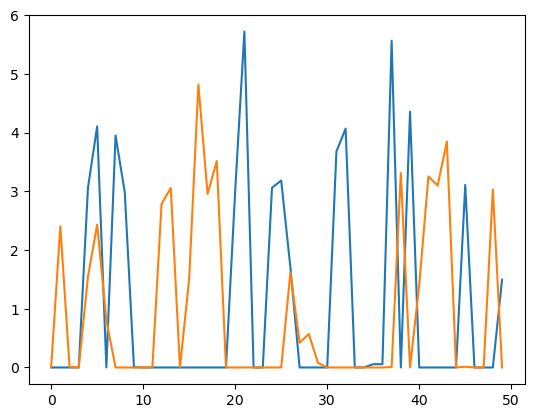

In [58]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)

## Application

In [69]:
def classify_report(report, model):
    completion = client.chat.completions.create(model=model,
                                               messages = [
                                                {"role": "system", "content": system_prompt},
                                                {"role": "user", "content": report}
                                               ])
    return completion

In [72]:
predicted_classes = []
ground_truth_classes = []

for line in test.iterrows():
    report, specialty = line[1]["report"], line[1]["medical_specialty"]
    ground_truth_classes.append(specialty.strip())  # in case of any spaces
    prediction = classify_report(report, model='gpt-3.5-turbo')
    predicted_classes.append(prediction.choices[0].message.content.strip())

In [73]:
import numpy as np
(np.array(predicted_classes) == np.array(ground_truth_classes)).mean() 

0.44

In [74]:
predicted_classes = []
ground_truth_classes = []

for line in test.iterrows():
    report, specialty = line[1]["report"], line[1]["medical_specialty"]
    ground_truth_classes.append(specialty.strip())  # in case of any spaces
    prediction = classify_report(report, model='ft:gpt-3.5-turbo-0125:personal::9CEHv0Bn')
    predicted_classes.append(prediction.choices[0].message.content.strip())

In [75]:
(np.array(predicted_classes) == np.array(ground_truth_classes)).mean() 

0.56

In conclusion, our experiment demonstrates the remarkable impact of fine-tuning with a subset of the data and just a single epoch on performance improvement. The observed 27% increase in performance underscores the efficacy of this approach in optimizing model outcomes.